In [27]:
# %pip install -q numpy matplotlib pandas scikit-learn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [28]:
def onehot(data, column):
    # Check if the column exists
    if column not in data.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame")

    # Handle missing values by filling them with a placeholder
    data[column].fillna('Missing', inplace=True)

    encoder = OneHotEncoder()
    encoder.fit(data[[column]])
    onehot_df = pd.DataFrame(encoder.transform(data[[column]]).toarray(), columns=encoder.get_feature_names_out([column]))
    
    # Ensure indices match for concatenation
    onehot_df.index = data.index

    data = pd.concat([data, onehot_df], axis=1)
    data.drop([column], inplace=True, axis=1)
    return data

In [29]:
# Import data
data = pd.read_csv('train.csv')
train, val = train_test_split(data, test_size=0.2)
test = pd.read_csv('test.csv')

# Preprocess data
train.drop(["Surname", "CustomerId", "id"], inplace=True, axis=1)
val.drop(["Surname", "CustomerId", "id"], inplace=True, axis=1)
test.drop(["Surname", "CustomerId", "id"], inplace=True, axis=1)

# Make onehot
train = onehot(train, "Geography")
train = onehot(train, "Gender")

val = onehot(val, "Geography")
val = onehot(val, "Gender")

test = onehot(test, "Geography")
test = onehot(test, "Gender")

# Make X, y
X_train, y_train = train.drop(["Exited"], axis=1), train["Exited"]
X_val, y_val = val.drop(["Exited"], axis=1), val["Exited"]


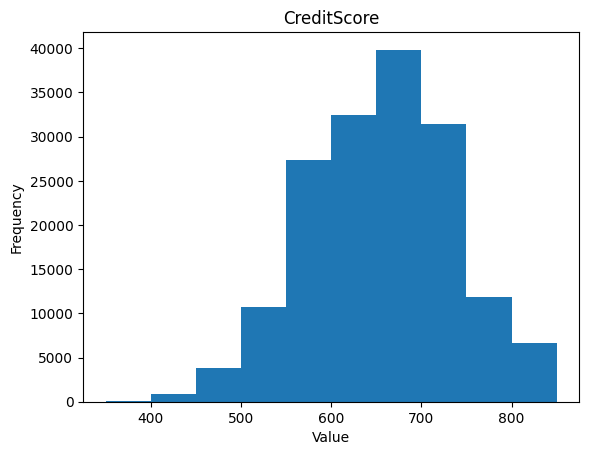

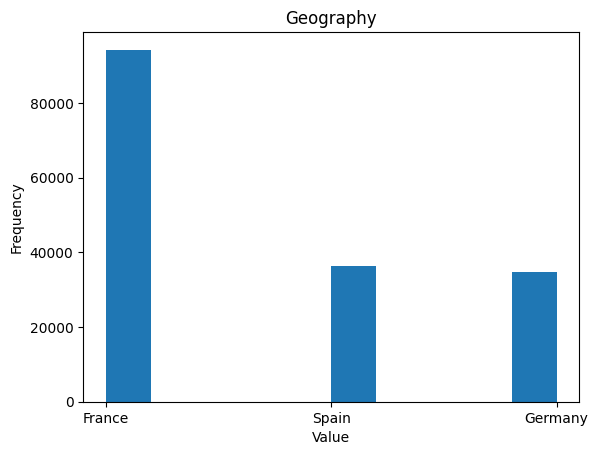

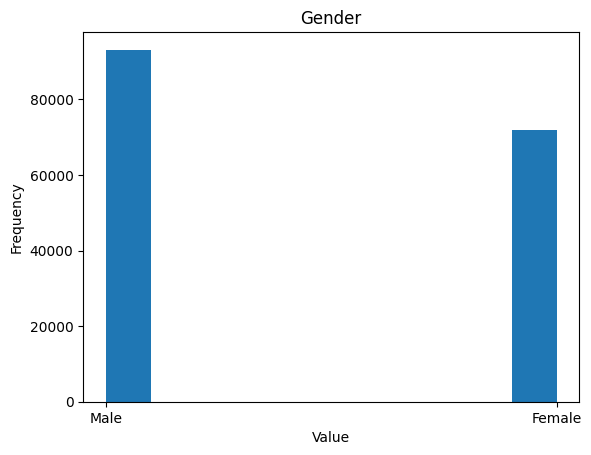

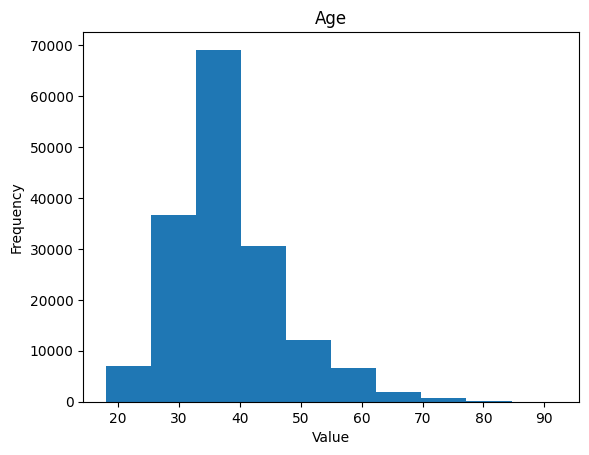

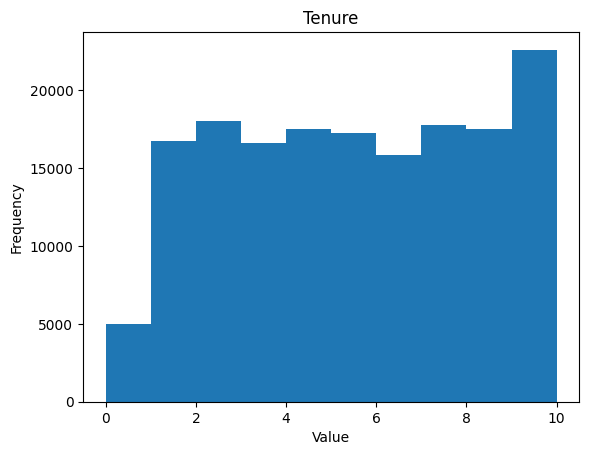

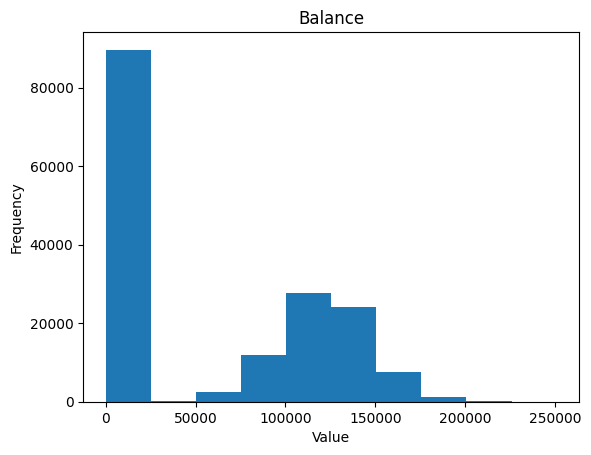

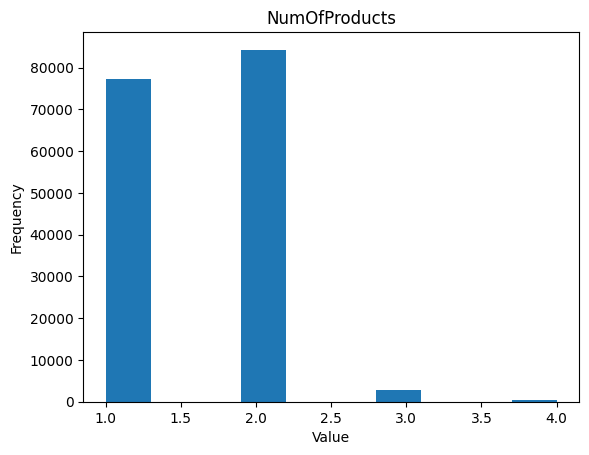

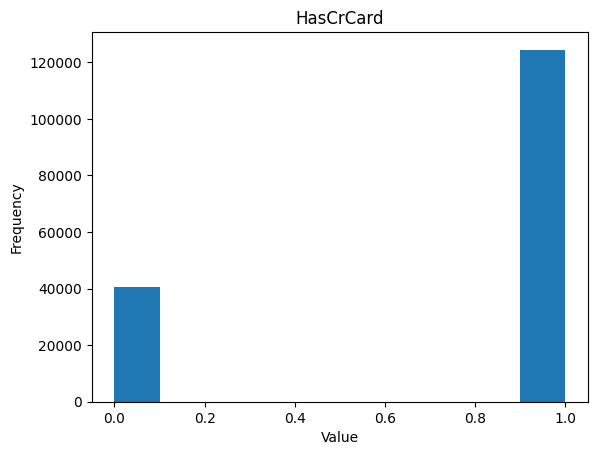

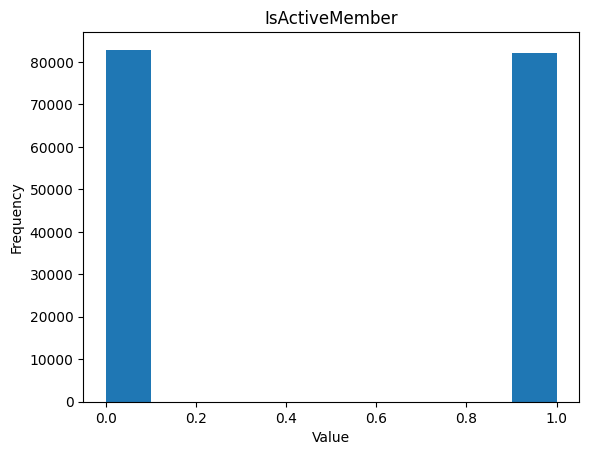

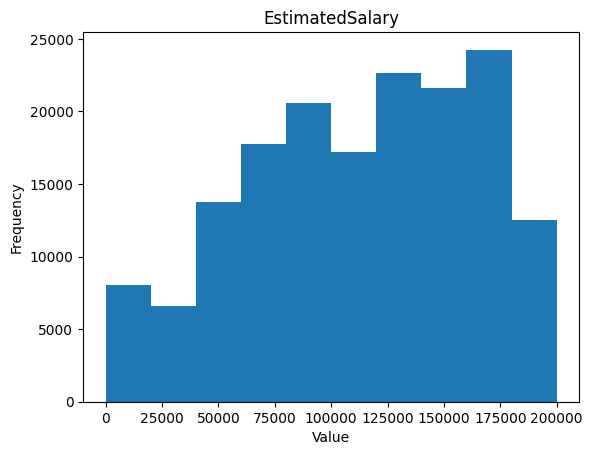

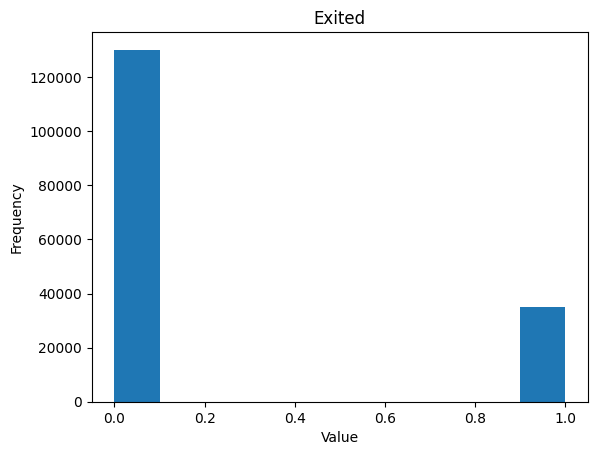

In [30]:
# Inspection of the data
# NOTE: Need to add interpretations of these plots
# e.g. The CreditScore is distributed almost normally with a slight skew to the left. This means that ...

# NOTE: MOST IMPORTANTLY, The target value "Exited" is imbalanced. This means that we need to take measures to handle this imbalance.
# And notably, accuracy is not a good performance metric for imbalanced data. We should consider using F1 score, precision, recall, or ROC-AUC instead.
features = data.columns
for feat in features:
    if feat in ["id", "CustomerId", "Surname"]:
        continue
    plt.hist(data[feat])
    plt.title(feat)
    plt.xlabel("Value")
    plt.ylabel("Frequency")    
    plt.show()

Logistic Regression
  Val accuracy 0.7871966552549459
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     26110
           1       0.46      0.12      0.19      6897

    accuracy                           0.79     33007
   macro avg       0.63      0.54      0.53     33007
weighted avg       0.73      0.79      0.73     33007



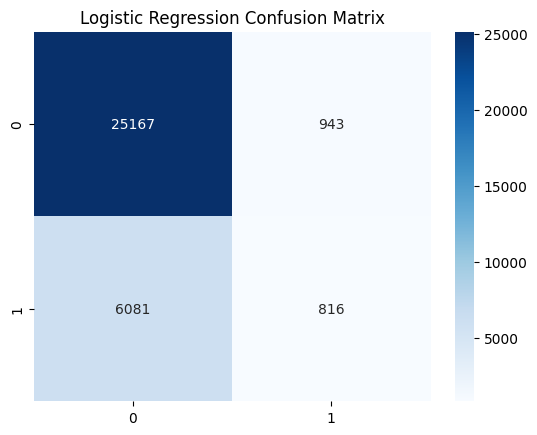

Random Forest Classifier
  Val accuracy 0.8587875299178962
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     26110
           1       0.72      0.54      0.61      6897

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007



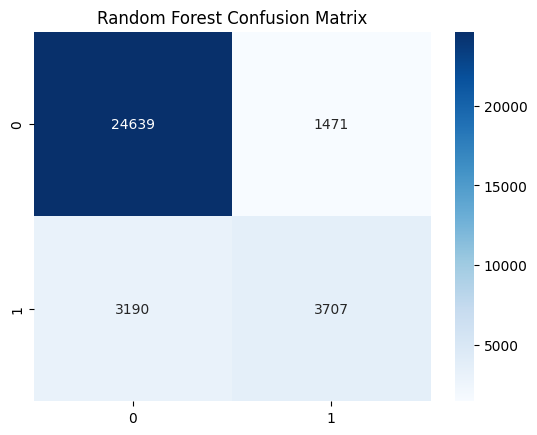

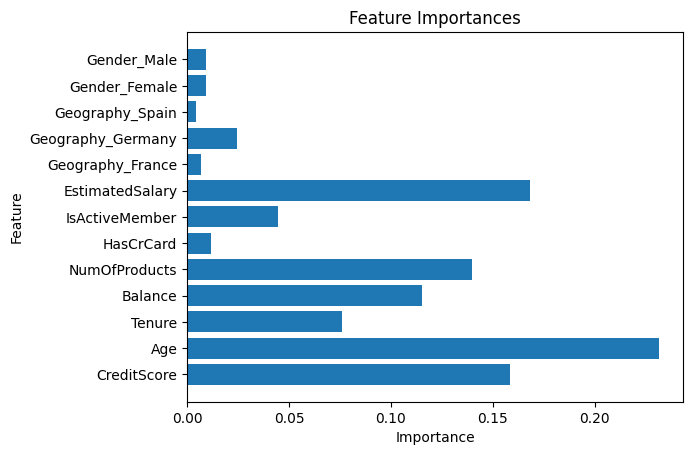

In [31]:
# Simple Logistic Regression model
print("Logistic Regression")
lr = LogisticRegression(penalty="l2")
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_val)
print("  Val accuracy", lr.score(X_val, y_val))
print(classification_report(y_val, y_pred_lr))

cf = confusion_matrix(y_val, y_pred_lr)
sns.heatmap(cf, annot=True, cmap='Blues', fmt='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Random Forest Classifier
print("Random Forest Classifier")
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
print("  Val accuracy", rf.score(X_val, y_val))
print(classification_report(y_val, y_pred_rf))

cf = confusion_matrix(y_val, y_pred_rf)
sns.heatmap(cf, annot=True, cmap='Blues', fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

plt.barh(X_train.columns, rf.feature_importances_)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

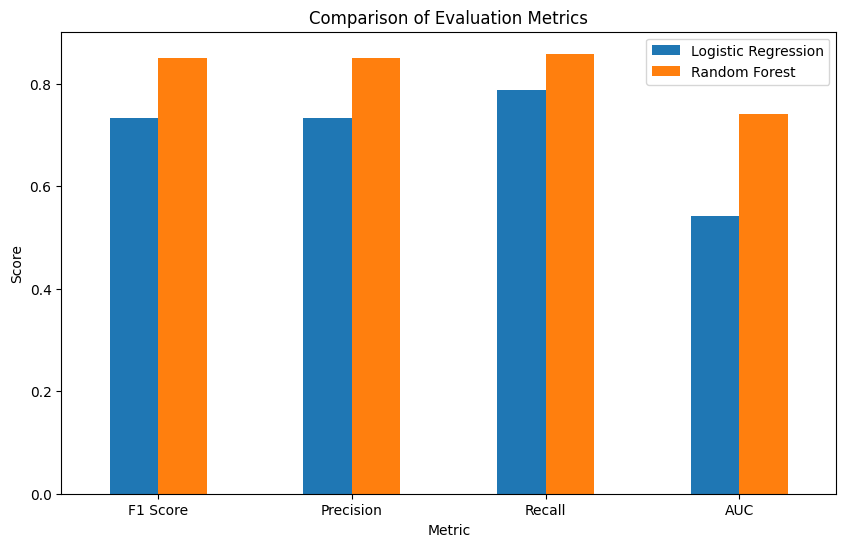

In [33]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate evaluation metrics
lr_f1 = f1_score(y_val, y_pred_lr, average='weighted')
rf_f1 = f1_score(y_val, y_pred_rf, average='weighted')
lr_precision = precision_score(y_val, y_pred_lr, average='weighted')
rf_precision = precision_score(y_val, y_pred_rf, average='weighted')
lr_recall = recall_score(y_val, y_pred_lr, average='weighted')
rf_recall = recall_score(y_val, y_pred_rf, average='weighted')
lr_auc = roc_auc_score(y_val, y_pred_lr, multi_class='ovr')
rf_auc = roc_auc_score(y_val, y_pred_rf, multi_class='ovr')

# Create DataFrame for plotting
metrics_df = pd.DataFrame({
    'Metric': ['F1 Score', 'Precision', 'Recall', 'AUC'],
    'Logistic Regression': [lr_f1, lr_precision, lr_recall, lr_auc],
    'Random Forest': [rf_f1, rf_precision, rf_recall, rf_auc]
})

# Plot the barplot
metrics_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Hyperparameter tuning
# ... using grid search

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [10, 100, 1000]
}

# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

# (took 5min 6s in python)

In [ ]:
# Using the best parameters:
# rf = RandomForestClassifier(n_estimators=1000, max_features='log2', max_depth=10)
# rf.fit(X_train, y_train)
# print("Using CV best parameters found for the Random Forest:")
# print("  Val score", rf.score(X_val, y_val))

In [ ]:
# Predictions on the test data, to hand in:

# test_predictions = rf.predict(test)
# test["Exited"] = test_predictions
# test[["id", "Exited"]].to_csv("test_predictions.csv", index=False)